# Basic Forecasting Methods

Firstly i going to introduce very basic methods and implementations and demonstrations.

## Average Approach

Just simple using average of all values to create a prevision.

$$\hat{y}_{T+h|T} = (y_1+\dots+y_T)/T$$

## Naive Approach

Just using the last value.

$$\hat{y}_{T+h|T} = y_T$$

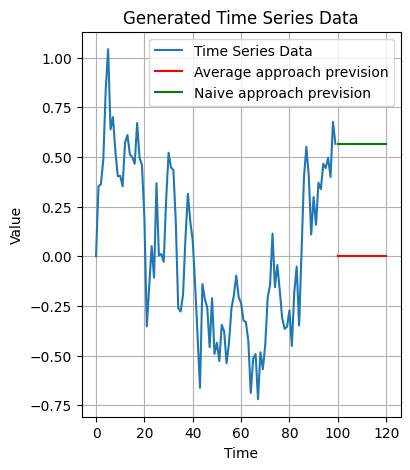

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def average(data):
    result = 0
    for t in data:
        result += t
    return result//data.size

np.random.seed(0)
data = np.zeros(100)
for t in range(1, 100):
    data[t] = 0.8 * data[t-1] + 0.2 * np.random.normal()

## Average approach
x2 = np.linspace(100, 120, 120)
y2 = np.full(120, average(data))

## Naive approach
x3 = np.linspace(100, 120, 120)
y3 = np.full(120, data[-1])


plt.figure(figsize=(14, 5))
plt.subplot(1, 3, 1)
plt.plot(data, label='Time Series Data')
plt.plot(x2, y2, label='Average approach prevision', color='r')
plt.plot(x3, y3, label='Naive approach prevision', color='g')
plt.title('Generated Time Series Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.legend()

## Drift Approach

$$ \hat{y}_{T+h|Y} = y_T + h\frac{y_T-y_1}{T-1}$$

Is visible based on the equation of a Straigh Line here $\frac{y_T-y_1}{T-1}$ is the Slope, basically uses the angle of the first and last value of the data.

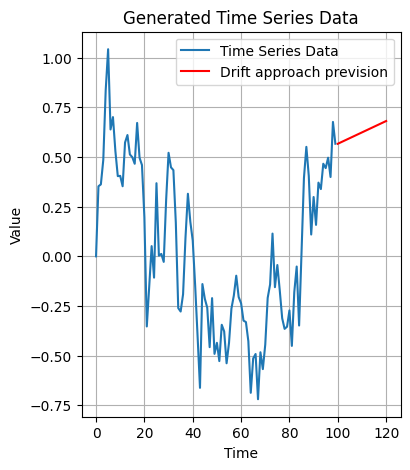

In [19]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)
T=100
data = np.zeros(T)
for t in range(1, T):
    data[t] = 0.8 * data[t-1] + 0.2 * np.random.normal()

## Drift approach
x2 = np.linspace(T, T + 20, 20)
y2 = data[-1] + (x2 - T)*((data[-1]-data[0])/(T-1)) 

plt.figure(figsize=(14, 5))
plt.subplot(1, 3, 1)
plt.plot(data, label='Time Series Data')
plt.plot(x2, y2, label='Drift approach prevision', color='r')
plt.title('Generated Time Series Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.legend()

## Seasonal Naive Approach

$$ \hat{y}_{T+h|Y}=y_{Y+h-m(k+1)} $$

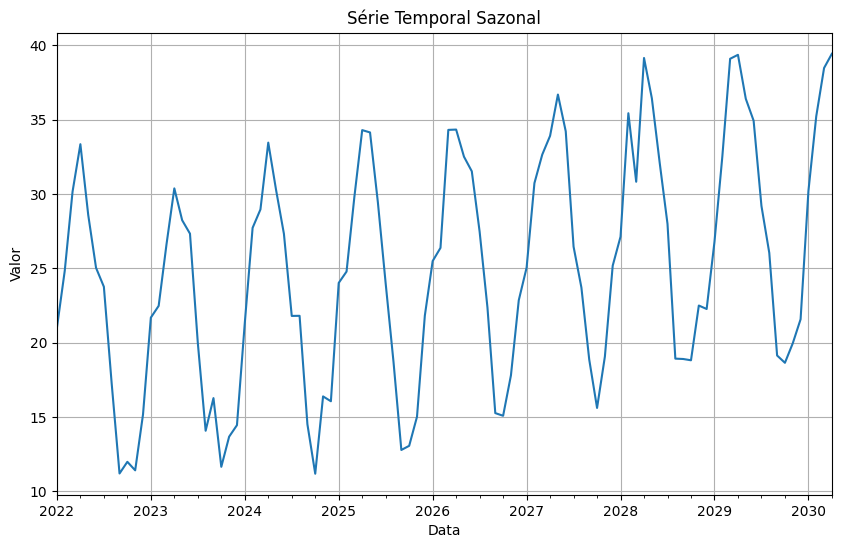

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)
periods = 100  
seasonal_period = 12
amplitude = 10 
trend = 0.1
noise_level = 2 

time = np.arange(periods)
seasonal = amplitude * np.sin(2 * np.pi * time / seasonal_period)
trend = trend * time
noise = noise_level * np.random.randn(periods)

series = 20 + trend + seasonal + noise

dates = pd.date_range(start='2022-01-01', periods=periods, freq='ME')
time_series = pd.Series(series, index=dates)

plt.figure(figsize=(10, 6))
time_series.plot()
plt.title('Série Temporal Sazonal')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.grid(True)
plt.show()